In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("traffic_training_data.csv")
data.shape

(962770, 12)

In [ ]:
anomalies = data[(data["vehicle_count"] == 1) & (data["current_speed"] == 0.0)]

data = data.drop(anomalies.index)
data["hour_of_day"] = data["hour_of_day"].astype(int)
data["current_speed"] = data["current_speed"].round(5)
data["congestion"] = data["congestion"].round(5)

# Create Lag Features (Context)
# We need to sort by time to define "previous".
# Assuming Day of Week follows standard order.
day_map = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
    "Friday": 4, "Saturday": 5, "Sunday": 6
}
data['day_code'] = data['day_of_week'].map(day_map)

# Sort by Entity (Street) then Time
data.sort_values(by=['edge_id', 'day_code', 'hour_of_day'], inplace=True)

data['congestion_lag_1'] = data.groupby('edge_id')['congestion'].shift(1)
data['congestion_lag_3'] = data.groupby('edge_id')['congestion'].shift(3)

data['congestion_rolling_mean_3'] = data.groupby('edge_id')['congestion'].shift(1).rolling(window=3).mean()

# Fill NaNs generated by shifting (first few hours of data)
data = data.dropna()

# Cyclic & Domain Features
data['hour_sin'] = np.sin(2 * np.pi * data['hour_of_day'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour_of_day'] / 24)
data["is_rush_hour"] = data["hour_of_day"].isin([7, 8, 9, 16, 17, 18]).astype(int)
data["is_weekend"] = data["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)

data.drop(columns=["current_speed", "day_code"], inplace=True) 

# Convert to categorical
data["hour_of_day"] = data["hour_of_day"].astype("category")
data["weather"] = data["weather"].astype("category")
data["street_type"] = data["street_type"].astype("category")
data["day_of_week"] = data["day_of_week"].astype("category")

# Drop ID now that structure is captured in lags
data.drop(columns=["edge_id"], inplace=True)

data.head()

,weather,day_of_week,hour_of_day,street_type,in_degree,out_degree,lane_count,max_speed,vehicle_count,congestion,congestion_lag_1,congestion_lag_3,congestion_rolling_mean_3,hour_sin,hour_cos,is_rush_hour,is_weekend
546036,Rain,Monday,12,highway.residential,4,4,1,8.33,1,0.57266,0.57266,0.38855,0.449920,1.224647e-16,-1.0,0,0
634683,Rain,Monday,12,highway.residential,4,4,1,8.33,1,0.57266,0.57266,0.38855,0.511290,1.224647e-16,-1.0,0,0
223132,Clear,Tuesday,4,highway.residential,4,4,1,8.33,1,0.38855,0.57266,0.57266,0.572660,8.660254e-01,0.5,0,0
728617,Rain,Tuesday,4,highway.residential,4,4,1,8.33,1,0.29605,0.38855,0.57266,0.511290,8.660254e-01,0.5,0,0
191370,Clear,Wednesday,4,highway.residential,4,4,1,8.33,1,0.38855,0.29605,0.57266,0.419087,8.660254e-01,0.5,0,0


In [3]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)



In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

target = "congestion"
X_train = train_data.drop(columns=[target])
y_train = train_data[target]
X_test = test_data.drop(columns=[target])
y_test = test_data[target]


def objective(trial):
    param = {
        "objective": "reg:squarederror",
        "verbosity": 0,
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float(
            "subsample", 0.6, 1.0
        ),  # Fraction of observations to be randomly samples for each tree
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.6, 1.0
        ),  # Fraction of columns to be randomly samples for each tree
        "random_state": 42,
        "enable_categorical": True,
    }

    model = xgb.XGBRegressor(**param, device="gpu")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = root_mean_squared_error(y_test, preds)
    return mse


# Create Study and Optimize
print("Starting Optuna Study...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)  # You can increase n_trials for better tuning

print("Best Parameters:", study.best_params)

# Train Final Model with Best Parameters
best_model = xgb.XGBRegressor(
    **study.best_params, objective="reg:squarederror", random_state=42, enable_categorical=True, device="gpu"
)
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)

print(f"Final Mean Absolute Error: {mae}")
print(f"Final Root Mean Squared Error: {rmse}")

/opt/anaconda/envs/kairo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-02-01 01:07:25,060] A new study created in memory with name: no-name-797d2457-fe86-427c-9e32-42e4ad49696b


Starting Optuna Study...


[I 2026-02-01 01:08:09,125] Trial 0 finished with value: 0.25307583698892466 and parameters: {'n_estimators': 234, 'learning_rate': 0.27795538189317975, 'max_depth': 15, 'subsample': 0.6330896359906274, 'colsample_bytree': 0.7064491958481756}. Best is trial 0 with value: 0.25307583698892466.
[I 2026-02-01 01:08:10,033] Trial 1 finished with value: 0.2390713620125906 and parameters: {'n_estimators': 145, 'learning_rate': 0.15064350377890243, 'max_depth': 4, 'subsample': 0.6677295627932068, 'colsample_bytree': 0.9461436845181554}. Best is trial 1 with value: 0.2390713620125906.
[I 2026-02-01 01:08:15,720] Trial 2 finished with value: 0.2358930029825362 and parameters: {'n_estimators': 121, 'learning_rate': 0.1957719352557602, 'max_depth': 12, 'subsample': 0.8523636795865965, 'colsample_bytree': 0.9193609349480278}. Best is trial 2 with value: 0.2358930029825362.
[I 2026-02-01 01:08:17,406] Trial 3 finished with value: 0.23706852403564302 and parameters: {'n_estimators': 245, 'learning_ra

Best Parameters: {'n_estimators': 305, 'learning_rate': 0.028034910571282948, 'max_depth': 10, 'subsample': 0.6927160563917217, 'colsample_bytree': 0.7344508704689517}
Final Mean Absolute Error: 0.18388654988800718
Final Root Mean Squared Error: 0.23462056952439808


Feature Impact: The model explains 31.12% of the variance in congestion.
Target Average: 0.5562
Target Std Dev: 0.2827
RMSE (0.18) vs Std Dev (0.2827):


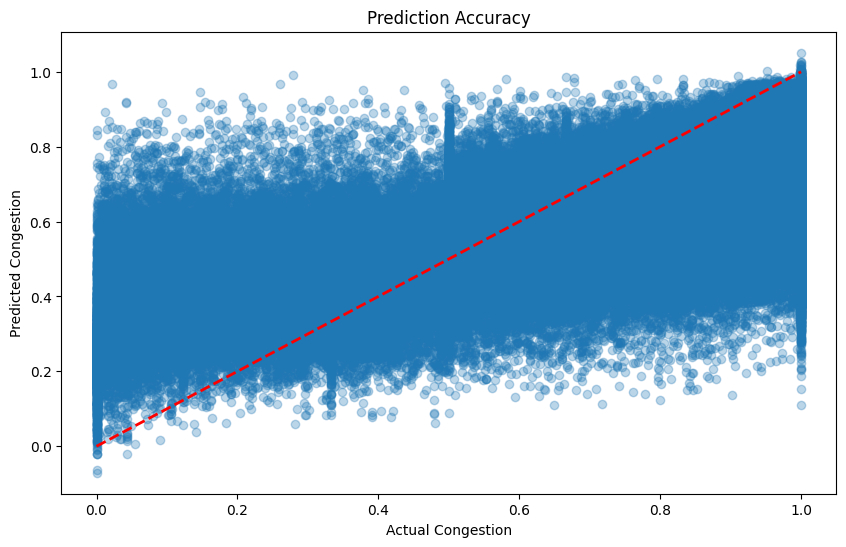

In [9]:
from sklearn.metrics import r2_score

#Calculate R2 Score (Accuracy relative to variance)
r2 = r2_score(y_test, predictions)

#  Target Statistics
target_mean = y_test.mean()
target_std = y_test.std()

print(f"Feature Impact: The model explains {r2*100:.2f}% of the variance in congestion.")
print(f"Target Average: {target_mean:.4f}")
print(f"Target Std Dev: {target_std:.4f}")
print(f"RMSE (0.18) vs Std Dev ({target_std:.4f}):")

# 3. Visual Check (Predicted vs Actual)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Congestion")
plt.ylabel("Predicted Congestion")
plt.title("Prediction Accuracy")
plt.show()